In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import wandb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, load_metric
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import nltk
import contractions

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno 104] Connection
[nltk_data]     reset by peer>
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv("Data/Suicide_Detection.csv",index_col=0)
df.reset_index(drop=True, inplace=True)
df = df.dropna()

In [4]:
# check the number of empty rows.
print(df['text'].apply(lambda x: x == '').sum())
# remove the empty rows
df = df[df['text'].apply(lambda x: len(x.split())!=0)]



0


In [5]:
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


<Axes: >

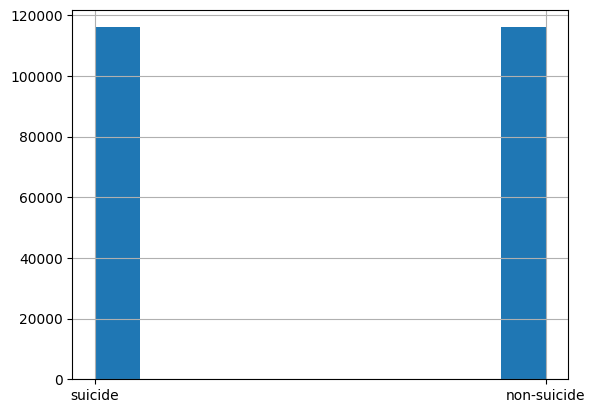

In [6]:
df['class'].hist()

### Preprocessing the dataset.

In [7]:
# Text normalization and cleaning
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.remove("not")

def clean_text(text):
    try:
        text = contractions.fix(text)  # remove contractions
    except:
        pass
    text = text.lower()  # convert text to lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\W', ' ', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove extra white spaces
    text = text.strip()  # remove leading and trailing white spaces
    word_tokens = word_tokenize(text)  # tokenize text
    filtered_text = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]  # remove stopwords and lemmatize
    # filtered_text = [lemmatizer.lemmatize(w) for w in word_tokens]  # lemmatize, stopword not removed as some context changed.
    return ' '.join(filtered_text)

df['text'] = df['text'].apply(clean_text)
# rename the column class to label
df.rename(columns={'class': 'label'}, inplace=True)

# encoder = LabelEncoder()
# df['class_label'] = encoder.fit_transform(df['class'])

In [14]:
df.head()
df.to_csv('Data/Suicide_Detection_Cleaned.csv', index=False)

,text,label
0,ex wife threatening suiciderecently left wife ...,suicide
1,weird not get affected compliment coming someo...,non-suicide
2,finally almost never hear bad year ever swear ...,non-suicide
3,need helpjust help cry hard,suicide
4,losthello name adam struggling year afraid pas...,suicide


In [19]:
dataset = Dataset.from_pandas(df)
dataset= dataset.remove_columns("__index_level_0__")
dataset = dataset.train_test_split(test_size=0.2)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 185659
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 46415
    })
})


In [20]:

dataset.push_to_hub("phr_suicide_prediction_dataset")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/186 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/47 [00:00<?, ?ba/s]